In [23]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

In [148]:
setwd('/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/GlyCompare/')

#### load libraries
source('example_notebook/functions.r')


clean<-function(x,skip=1,annot){
    x=cbind(annot,x)
    x$Secretor = ! x$Pateint.ID %in% c('L2','L3')
    x$scretor_col = ifelse(x$Secretor,'black','grey')
    x$DPP_col = heat.colors(length(unique(x$DPP)))[factor(x$DPP)]
    x$subject_col = rainbow(length(levels(x$Pateint.ID)))[x$Pateint.ID]
    x
}

##### load & prep data
annot = na.omit(read.csv('example_data/paper_hmo/source_data/annotation.csv'))
#head(annot)

tmp=t(data.matrix(read.csv('example_data/paper_hmo/intermediate_file/paper_hmo_motif_abd_table.csv',row.names=1,header =TRUE)))
colnames(tmp) = paste0('X',colnames(tmp))
rownames(tmp) = NULL
smandm = clean( tmp,annot=annot)

tmp<-read.csv('example_data/paper_hmo/source_data/abundance_table.csv')[-41,-1]
tmp$SUM=rowSums(tmp)
gly = clean ( tmp,annot=annot )

head(smandm)
head(gly)

vars = gsub('\\.','',c( grep('X',colnames(smandm),value=T), colnames(gly)[4:19] ))

gly_p = gly
gly_p[,colnames(gly)[4:19]] = gly[,colnames(gly)[4:19]]/as.numeric(as.character(gly$SUM))

data=list(#motif_abundance=ma,motif_abundance_dropped=mand,#motif_abundance_dropped_more=mandm,
    smallest_motif_abundance_dropped_more=smandm,
    #glycan_concentration=gly, ## we chose not to work with concentration to remain consistent with the rest of the paper
    glycan_percent=gly_p)

data = lapply(data,function(x){
    colnames(x) = gsub('\\.','',colnames(x))
    x
})

keep_data=c('smallest_motif_abundance_dropped_more','glycan_percent')#,'glycan_percent')

#######################


Dataset,Pateint.ID,DPP,X1,X4,X8,X13,X15,X18,X32,⋯,X113,X120,X127,X141,X142,X143,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,0.19166973,0.7856543,0.06204399,0.6677340,0.15944045,0.2499081,0.07891974,⋯,0.05178206,0.002598289,0.013227652,0.0013385124,0.005012860,0.0082147919,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,0.11718214,0.8259251,0.06456775,0.7357523,0.08697214,0.3489010,0.05561906,⋯,0.04275123,0.001698292,0.007511676,0.0048662595,0.007250400,0.0002612757,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,0.07822616,0.7939394,0.07757576,0.7167775,0.03228381,0.5018477,0.05194383,⋯,0.04795270,0.002690318,0.006001478,0.0007982262,0.004050259,0.0019512195,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,0.09139850,0.7912533,0.09345512,0.7062061,0.03405517,0.5156666,0.05873458,⋯,0.05676869,0.004445923,0.010555287,0.0011492862,0.006986451,0.0035688362,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,0.06754382,0.7672239,0.07069797,0.6536746,0.04064345,0.5264723,0.07326635,⋯,0.07141892,0.009958095,0.014689316,0.0036047402,0.012165998,0.0025233182,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,0.08962425,0.7456007,0.10180919,0.6507500,0.03593629,0.5584970,0.05650224,⋯,0.05628576,0.006680068,0.013885882,0.0019174269,0.010731406,0.0031544766,TRUE,black,#FFFF00FF,#FF0000FF


Dataset,Pateint.ID,DPP,X2.FL,X3FL,LNnT,X3.SL,LNT,LNFP.I,LNFP.II,⋯,DSLNT,FLNH,DFLNH,FDSLNH,DSLNH,SUM,Secretor,scretor_col,DPP_col,subject_col
<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<lgl>,<chr>,<chr>,<chr>
1,L1,1,21765,1034,295,5781,882,3578,435,⋯,243,99,191,313,51,38102,TRUE,black,#FF0000FF,#FF0000FF
1,L1,2,17207,394,327,2335,1423,5269,431,⋯,179,52,222,8,149,30619,TRUE,black,#FF3300FF,#FF0000FF
1,L1,3,15841,135,748,874,3642,8313,506,⋯,191,91,137,66,27,33825,TRUE,black,#FF6600FF,#FF0000FF
1,L1,4,15213,65,735,736,3263,7990,444,⋯,352,147,231,118,38,33064,TRUE,black,#FF9900FF,#FF0000FF
1,L1,7,9739,41,381,729,3342,4547,504,⋯,93,221,270,56,80,22193,TRUE,black,#FFCC00FF,#FF0000FF
1,L1,14,13347,7,843,922,4587,7479,565,⋯,178,216,347,102,62,32335,TRUE,black,#FFFF00FF,#FF0000FF


### examine glycan and motif level clustering (Supp Fig6)

In [233]:

# col=rev(hcl.colors(20,palette = 'YlOrRd'))

# #pdf('~/Desktop/hmoclusters2.pdf',height=10,width=10)
# ## glycan abundance
# x=data$glycan_percent
# data_i = data.matrix(x[,colnames(x)%in%vars])
# rownames(data_i) = paste(x$PateintID,ifelse(x$Secretor,': Secretor',''))
# cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
# heatmap.2( data_i,RowSideColors=cols[,1],main='Glycan Relative Abundance (% nmol/mL)', scale='none',col=col,trace='none',
#     hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
          
# ## motif abundance        
# x=data$smallest_motif_abundance_dropped_more
# data_i = data.matrix(x[,colnames(x)%in%vars])
# rownames(data_i) = paste(x$PateintID,ifelse(x$Secretor,': Secretor',''))
# cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
# heatmap.2( data_i,RowSideColors=cols[,1],main='Motif Relative Abundance', scale='none',col=col,trace='none',
#     hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
# #dev.off()


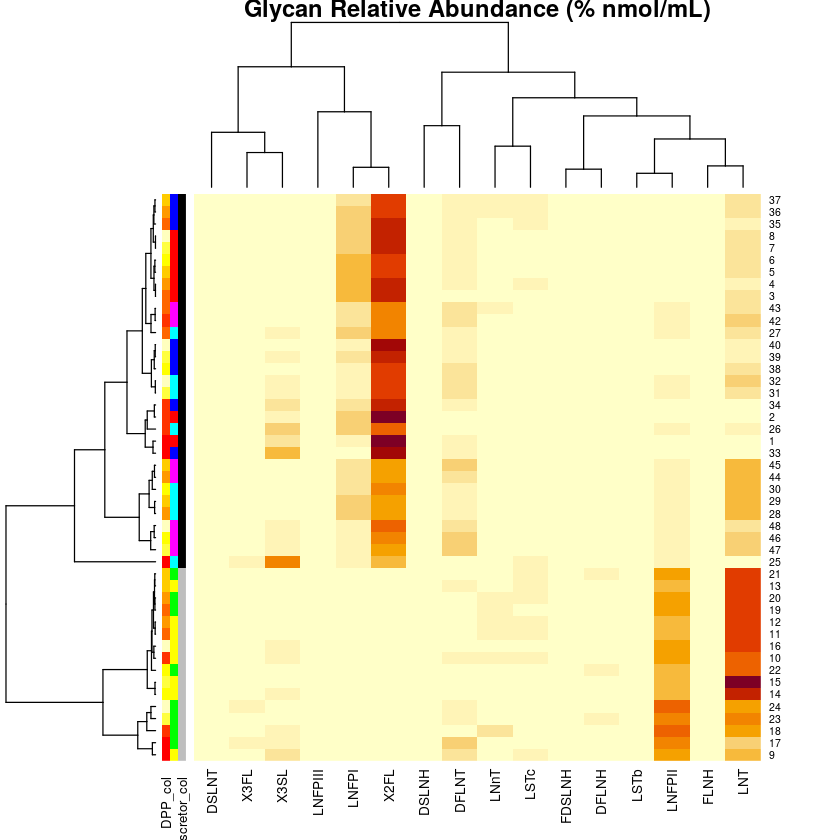

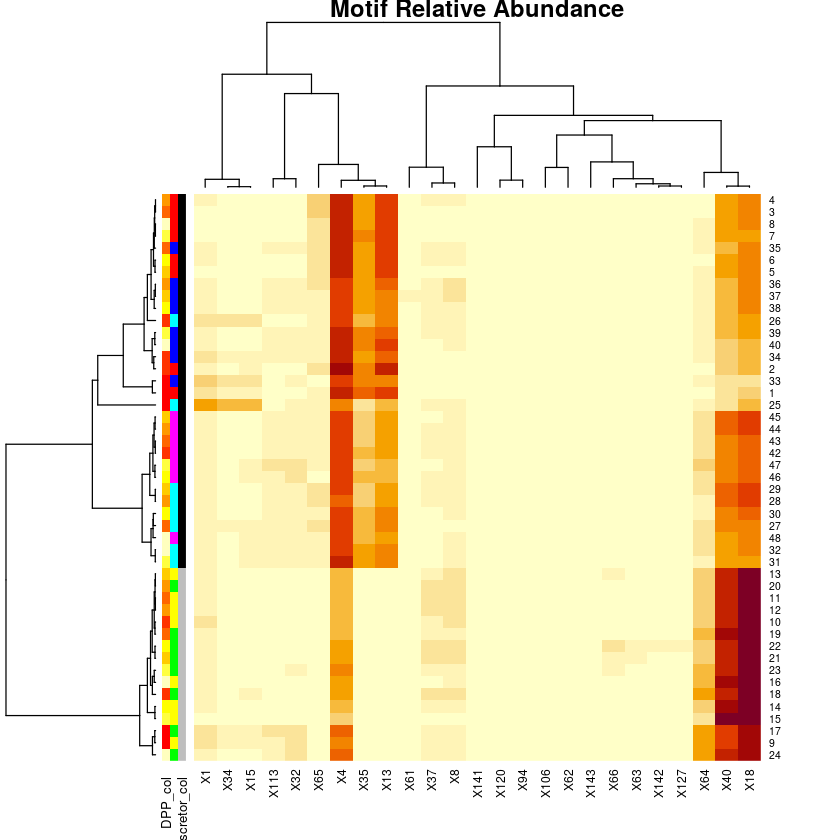

In [284]:

#pdf('~/Desktop/hmoclusters.pdf',height=10,width=10)
## glycan abundance
x=data$glycan_percent
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='Glycan Relative Abundance (% nmol/mL)', scale='none',
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
colorbar.plot( 2.5, 30, 1:15,col=hcl.colors(20,palette = 'Lajolla'))
          
## motif abundance        
x=data$smallest_motif_abundance_dropped_more
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='Motif Relative Abundance', scale='none',
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))
#dev.off()

# Phenotype-Glycan & Phenotype-Motif Abundance Associations


## Predictability of every glycan and motif from Secretor status and DPP (Supp Fig8, Fig4b)
This analysis discovered several motifs signifiantly associated with secretor status and DPP, including X80

In [285]:
library(gee)

add_models=list()
inter_models=list()

i=0
out_i=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods1
})
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))


#############
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))

library(geepack) 
              
# get whole models
out_models=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
#        try(mod<-geeglm(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
#        try(mod<-geeglm(as.formula(paste('Secretor~log(DPP)+scale(',motif,')')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods_i
})

Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.183      -0.218      -0.549 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -1.241       1.807       0.026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.9855     -1.2908     -0.0708 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.4423      2.0422      0.0503 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.475       0.256      -0.340 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.825      -1.692       0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -0.5759      0.6911      0.0634 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.442       0.344      -0.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.3905      2.0598      0.0169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.225      -1.085      -0.269 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.671      -1.629       0.213 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.293      -0.510      -0.505 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.724      -1.390       0.102 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.7648     -1.2174      0.0201 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.859      -1.651       0.121 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.2859      1.7964      0.0534 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.184      -1.253       0.339 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.320      -0.942       0.497 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0297     -0.4065      0.1259 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.815       0.736       0.174 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0749     -1.2852      0.4081 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.553      -1.283       0.155 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.746      -0.268       0.488 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.374      -1.369       0.280 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.760      -0.710      -0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    -1.3905      2.0598      0.0169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.937      -0.935      -0.169 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.5386     -0.7320     -0.0295 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.442       0.344      -0.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.415      -1.498       0.303 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  -1.283776    1.944580    0.000624 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     1.0743     -1.8301      0.0701 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.208       0.479      -0.277 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
    1.20859    -1.84330     0.00381 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      1.199      -0.368      -0.505 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.815       0.736       0.174 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.813       0.130      -0.475 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     0.0749     -1.2852      0.4081 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.374      -1.369       0.280 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
      0.760      -0.710      -0.154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
     -0.746      -0.268       0.488 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na

In [307]:
mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP)*Secretor,
    id=PateintID,data=data$glycan_percent ,corstr='exchangeable')
summary(mod)

mod<-geeglm(scale(log(X62+.0001))~ log(DPP)*Secretor,
    id=PateintID,data=data$smallest_motif_abundance_dropped_more ,corstr='exchangeable')
summary(mod)
#parseSummary.GEEpack(mod,sigfig)


Call:
geeglm(formula = scale(log(LSTb + 1e-04)) ~ log(DPP) * Secretor, 
    data = data$glycan_percent, id = PateintID, corstr = "exchangeable")

 Coefficients:
                      Estimate Std.err Wald Pr(>|W|)    
(Intercept)             1.5168  0.2834 28.6  8.7e-08 ***
log(DPP)               -0.1704  0.0500 11.6  0.00065 ***
SecretorTRUE           -2.3350  0.3288 50.4  1.2e-12 ***
log(DPP):SecretorTRUE   0.2801  0.0743 14.2  0.00016 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Estimated Scale Parameters:
            Estimate Std.err
(Intercept)    0.205  0.0217

Correlation: Structure = exchangeable  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha     0.34   0.116
Number of clusters:   6   Maximum cluster size: 8 


Call:
geeglm(formula = scale(log(X62 + 1e-04)) ~ log(DPP) * Secretor, 
    data = data$smallest_motif_abundance_dropped_more, id = PateintID, 
    corstr = "exchangeable")

 Coefficients:
                      Estimate Std.err   Wald Pr(>|W|)    
(Intercept)             1.5893  0.0345 2126.7   <2e-16 ***
log(DPP)               -0.3665  0.0114 1033.5   <2e-16 ***
SecretorTRUE           -2.6856  0.1502  319.6   <2e-16 ***
log(DPP):SecretorTRUE   0.7032  0.0723   94.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Estimated Scale Parameters:
            Estimate Std.err
(Intercept)    0.362  0.0876

Correlation: Structure = exchangeable  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha     0.41   0.124
Number of clusters:   6   Maximum cluster size: 8 

In [304]:
x=data$smallest_motif_abundance_dropped_more

sigfig=5

mod<-geeglm(scale(log(X62+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

x=data$smallest_motif_abundance_dropped_more
mod<-geeglm(scale(log(X62+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)



x=data$glycan_percent

print('LSTb')
mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

mod<-geeglm(scale(log(LSTb+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

print('DSLNT')
mod<-geeglm(scale(log(DSLNT+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

mod<-geeglm(scale(log(DSLNT+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

print('DSLNH')
mod<-geeglm(scale(log(DSLNH+.0001))~ log(DPP),
    id=PateintID,data=x[ x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

mod<-geeglm(scale(log(DSLNH+.0001))~ log(DPP),
    id=PateintID,data=x[ !x$Secretor,] ,corstr='exchangeable')
parseSummary.GEEpack(mod,sigfig)

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.74 & (-0.48819 - -0.9957) & 0.00 \\ 
  log(DPP) & 0.40 & (0.33284 - 0.46529) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.27 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.61 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.22 & (1.0705 - 1.3654) & 0.00 \\ 
  log(DPP) & -0.66 & (-0.63058 - -0.6832) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.69 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.88 \\ 
   \hline
\end{tabular}
\end{table}

[1] "LSTb"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.39 & (-0.13891 - -0.64786) & 0.23 \\ 
  log(DPP) & 0.22 & (0.17095 - 0.26372) & 0.05 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.09 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.99 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.67 & (-0.11446 - 1.4473) & 0.26 \\ 
  log(DPP) & -0.36 & (-0.28515 - -0.43372) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.21 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.93 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNT"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.74 & (0.16746 - 1.3195) & 0.06 \\ 
  log(DPP) & -0.39 & (-0.17451 - -0.60313) & 0.17 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.22 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.08 & (0.90883 - 1.2538) & 0.00 \\ 
  log(DPP) & -0.58 & (-0.55665 - -0.60976) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:36 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.54 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.22 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNH"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:37 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.99 & (-0.42991 - -1.5561) & 0.00 \\ 
  log(DPP) & 0.53 & (0.39235 - 0.66399) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:37 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 31.00 \\ 
  2 & Number of Clusters & 4.00 \\ 
  3 & Marginal R\verb|^|2 & 0.45 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 29.00 \\ 
  6 & Shapiro-Wilks P & 0.24 \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:37 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.66 & (-0.55101 - -0.77302) & 0.00 \\ 
  log(DPP) & 0.36 & (0.312 - 0.4021) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 19:16:37 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 16.00 \\ 
  2 & Number of Clusters & 2.00 \\ 
  3 & Marginal R\verb|^|2 & 0.20 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 14.00 \\ 
  6 & Shapiro-Wilks P & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

In [288]:
xtabs=lapply(out_models$smallest_motif_abundance_dropped_more,parseSummary.GEEpack,odsig=4)
#print(xtabs$X80)
print('x62')
(xtabs$X62)

xtabs2=lapply(out_models$glycan_percent,parseSummary.GEEpack,odsig=4)
#print(xtabs$X80)

print('lstb')
(xtabs2$LSTb)
print('dslnt')
(xtabs2$DSLNT)
print('DSLNH')
(xtabs2$DSLNH)

#### to see all motif and glycan models, uncomment the next line of code
#xtabs   # motifs
#xtabs2 #glycans

[1] "x62"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.74 & (0.3485 - 1.132) & 0.01 \\ 
  Secretor & -1.37 & (-0.6422 - -2.095) & 0.00 \\ 
  log(DPP) & 0.09 & (0.06535 - 0.1174) & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.45 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.53 \\ 
   \hline
\end{tabular}
\end{table}

[1] "lstb"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 1.18 & (0.5933 - 1.766) & 0.00 \\ 
  Secretor & -1.81 & (-0.9251 - -2.695) & 0.00 \\ 
  log(DPP) & 0.01 & (0.009961 - 0.01298) & 0.86 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.76 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

[1] "dslnt"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.78 & (0.285 - 1.268) & 0.02 \\ 
  Secretor & 0.16 & (0.1216 - 0.2038) & 0.21 \\ 
  log(DPP) & -0.47 & (-0.3124 - -0.6257) & 0.01 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.34 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.22 \\ 
   \hline
\end{tabular}
\end{table}

[1] "DSLNH"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & -0.74 & (-0.5004 - -0.9808) & 0.00 \\ 
  Secretor & -0.23 & (-0.1115 - -0.3393) & 0.38 \\ 
  log(DPP) & 0.47 & (0.3884 - 0.5597) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Sun Jul 21 18:28:20 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.36 \\ 
  4 & Marginal Entropy &  \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P & 0.07 \\ 
   \hline
\end{tabular}
\end{table}

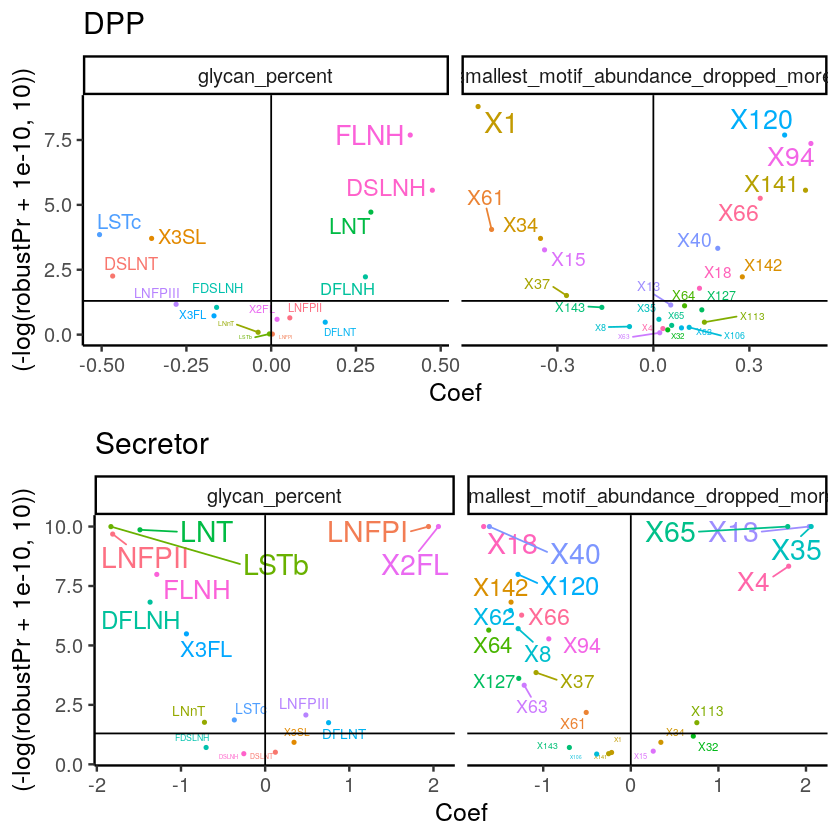

In [289]:
library(cowplot)


g1=ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='DPP',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+
    theme_classic(base_size=15)+ggtitle('DPP')
g1Leg = get_legend(g1)
g1 <- g1+ guides(color=FALSE,size=FALSE)

g2<-ggplot( data=droplevels(out[out$type=='additive'& out$data%in%keep_data &out$vars=='Secretor',]), # & !grepl('DPP',rownames(out)),]) ,
       aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response))+
    geom_text_repel() + #scale_x_continuous(trans='log2') +
    facet_grid(~data,scale='free')+geom_point(size=.8)+#geom_path(size=.3)+
    geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+ 
    theme_classic(base_size=15)+ggtitle('Secretor')
g2Leg = get_legend(g2)
g2 <- g2+ guides(color=FALSE,size=FALSE)

g = grid.arrange(grobs=list(g1,g2),nrow=2)

ggsave(g,filename = '~/Desktop/suppfig8.pdf',height=10,width=10)
ggsave(g1Leg,filename = '~/Desktop/suppfig8.leg.pdf',height=15,width=15)


## Demonstration that X80 behaves distinctly from its related glycans (Fig4b)

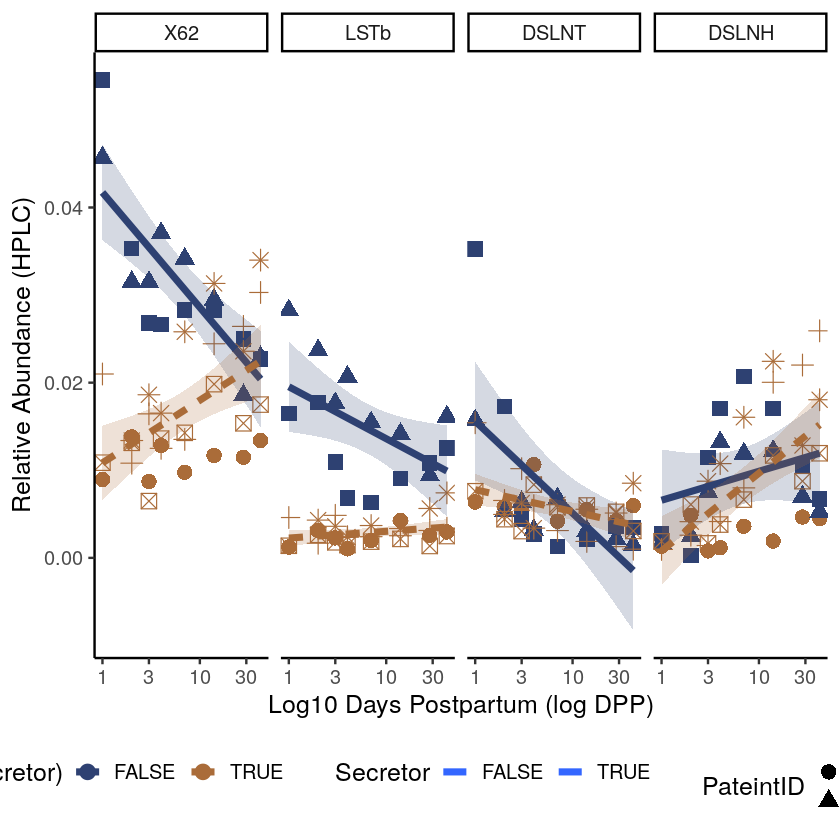

In [290]:
tmp= melt(cbind( data$smallest_motif_abundance_dropped_more[,c('DPP','X62','Secretor','PateintID')],data$glycan_percent[,c('DSLNT','DSLNH','LSTb')]) , id.vars=c('DPP','Secretor','PateintID'))

tmp$variable = factor(tmp$variable,levels=c('X62','LSTb','DSLNT','DSLNH'))
g<-ggplot(data=droplevels(tmp),aes(x=DPP,y=value,linetype=Secretor,color=factor(Secretor)))+
		geom_point(aes(shape=PateintID),size=4)+scale_x_log10()+
		xlab('Log10 Days Postpartum (log DPP)')+ylab('Relative Abundance (HPLC)')+
		stat_smooth(method='lm',size=2,alpha=.2,se=T,aes(fill=Secretor))+facet_grid(cols=vars(variable))+ 
        theme_classic(base_size = 15)+theme(legend.position="bottom")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+scale_fill_manual(values=c("#2E4172", "#AA6C39"))+
        guides(linetype=F)
g
ggsave(g,filename = '~/Desktop/fig4b.pdf',height=6,width=15)

## Using the Product-Reactant ratio association to phenotype to determine important reactions in biosynthesis (Fig5 supporting exploration)

In [343]:
#### load heirachy
r = read.csv('example_data/paper_hmo/intermediate_file/edges.txt',header=FALSE)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data$smallest_motif_abundance_dropped_more

comp=list()
comp_clean=list()
p = c(); lfc=c()
for( e in E(heir)){
    p = c(p,1);
    lfc=c(lfc,0);

    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));next}
    # run models
    f1 = Secretor ~ log(DPP)
    f2 = as.formula(paste0('Secretor ~ log(DPP) + I(',paste(paste0('X',rev(en)),collapse='/'),')'  ) )

    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    f0 = as.formula(paste0('Secretor ~ scale(X',en[1],')'))
    f = as.formula(paste0('Secretor ~  scale(X',en[1],') + scale(X',en[2],')'  ) )

    m0 = geeglm( f0, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m = geeglm( f , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    aov = anova(m0,m,test='LRT')

    out = data.frame( coef(summary(m2)) )
    out$iter = paste(en,collapse='_')
    out$vars = rownames(out)
    out$LRT = aov[[3]]

    #if(any(abs(out$Estimate)>15)){next}

    p[length(p)] = aov[[3]]
    lfc[length(lfc)] = coef(summary(m2))[3,1]

    comp[[paste(en,collapse='_')]] = list(m1,m2,aov,m)
    comp_clean[[paste(en,collapse='_')]] = out
}

out=do.call(rbind,comp_clean)
out = out[!grepl('Intercept|DPP',rownames(out)),]
#write.csv(out,file='motifAnyl/motif_heir.12.7.18.Bokan/stats.csv')


     [,1] [,2]
[1,] "5"  "18"
[1] "skip 5_18"
     [,1] [,2]
[1,] "5"  "32"
[1] "skip 5_32"
     [,1] [,2]
[1,] "5"  "34"
[1] "skip 5_34"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "18" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "18" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "37" "61"
     [,1] [,2]
[1,] "37" "63"
     [,1] [,2]
[1,] "40" "62"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "64"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "62" "106"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "64" "113"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "66" "94"
     [,1] [,2] 
[1,] "94" "120"
     [,1]  [,2] 
[1,] "127" "142"



	Welch Two Sample t-test

data:  I(X65/X40) by Secretor
t = -14, df = 31, p-value = 1e-14
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.358 -0.264
sample estimates:
mean in group FALSE  mean in group TRUE 
             0.0509              0.3623 


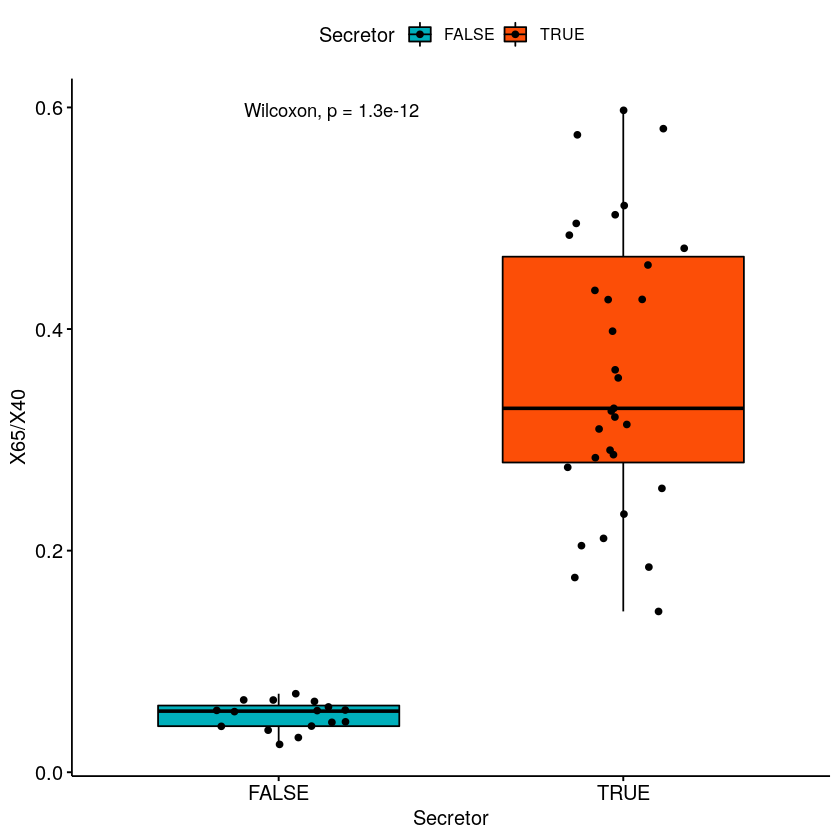

In [336]:
#ggplot(data$smallest_motif_abundance_dropped_more,aes(x=X40,y=X65,color=Secretor))+geom_point()

#ggplot(data$smallest_motif_abundance_dropped_more,aes(y=X65/X40,x=Secretor))+geom_point()+geom_boxplot()

ggboxplot(data$smallest_motif_abundance_dropped_more,x='Secretor',y='X65/X40',
                fill = "Secretor", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means()
t.test(I(X65/X40)~Secretor,data=data$smallest_motif_abundance_dropped_more)

In [351]:
#out$q = p.adjust(out$'Pr...W..','fdr')
#hist(out$q,main='FDR corrected significance of Likelihood Ratio Test\n(significantly secretion-associated reactions)')
sub<-out[out$'Pr...W..'<.05,]
sub[order(sub$'Pr...W..'),]
# E(heir)$p = p
# E(heir)$lfc = lfc
# E(heir)$q = p.adjust(p,'fdr')

# E(heir)$weight = (-log(E(heir)$q+.01,10)*10+.5)
# V(heir)$weight = strength(heir,mode='out')


# #pdf('motifAnyl/motif_heir.12.7.18.Bokan/significance_network.pdf',height=10,width=10)
# plot(heir,layout=layout_as_tree(heir),
#     edge.width=E(heir)$weight,edge.arrow.size=0,#edge.color=E(heir)$color,
#     vertex.size=5,vertex.label.cex=1,vertex.label.family='sans',
#     vertex.color=NA,vertex.frame.color=NA,main=)

df=with(data$smallest_motif_abundance_dropped_more,{
    data.frame(x65_x40 =X65/X40,x62_x40 =X62/X40,x106_x65=X106/X62,sec=Secretor)
})

aggregate(df[,1:3],by=list(df$sec),function(x) c(mean(x),sd(x)))

(parseSummary.GEEpack(comp$'40_62'[[2]],6,logit=TRUE))
(parseSummary.GEEpack(comp$'62_106'[[2]],6,logit=TRUE))

(parseSummary.GEEpack(comp$'40_65'[[2]],6,logit=TRUE))




,Estimate,Std.err,Wald,Pr...W..,iter,vars,LRT
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
40_65.I(X65/X40),905.61451,0.98495,8.45e+05,0.0000,40_65,I(X65/X40),0.0000
37_61.I(X61/X37),-0.01910,0.00761,6.31e+00,0.0120,37_61,I(X61/X37),0.0000
62_106.I(X106/X62),-0.05262,0.02231,5.56e+00,0.0183,62_106,I(X106/X62),0.0487
37_63.I(X63/X37),0.00765,0.00378,4.09e+00,0.0430,37_63,I(X63/X37),0.0000


Group.1,x65_x40,x62_x40,x106_x65
<lgl>,"<dbl[,2]>","<dbl[,2]>","<dbl[,2]>"
FALSE,"0.0509, 0.0131","0.0403, 0.0141","0.523, 0.1512"
TRUE,"0.3623, 0.1268","0.0414, 0.0178","0.818, 0.0723"


[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.00 & (-1.39521 - 5.39784) & 0.42 \\ 
  log(DPP) & 1.00 & (0.999763 - 1.00003) & 0.14 \\ 
  I(X62/X40) & 0.99 & (0.957091 - 1.02266) & 0.55 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 1.00 \\ 
  4 & Marginal Entropy & 0.50 \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 2.07 & (-1.48709 - 5.63095) & 0.41 \\ 
  log(DPP) & 1.00 & (0.998646 - 1.00133) & 0.99 \\ 
  I(X106/X62) & 0.95 & (0.907258 - 0.990221) & 0.02 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 1.00 \\ 
  4 & Marginal Entropy & 0.50 \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

[[1]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rrlr}
  \hline
 & Coef & 95 CI & Pr(W) \\ 
  \hline
(Intercept) & 0.00 & (-8.94612e-48 - 4.59395e-47) & 0.00 \\ 
  log(DPP) & 40.61 & (38.8148 - 42.3968) & 0.00 \\ 
  I(X65/X40) & Inf & (NaN - Inf) & 0.00 \\ 
   \hline
\end{tabular}
\end{table}

[[2]]
% latex table generated in R 3.6.1 by xtable 1.8-4 package
% Mon Jul 22 00:16:25 2019
\begin{table}[ht]
\centering
\begin{tabular}{rlr}
  \hline
 & stat & value \\ 
  \hline
1 & Number of observations & 47.00 \\ 
  2 & Number of Clusters & 6.00 \\ 
  3 & Marginal R\verb|^|2 & 0.71 \\ 
  4 & Marginal Entropy & 1.00 \\ 
  5 & Degrees of Freedom & 44.00 \\ 
  6 & Shapiro-Wilks P &  \\ 
   \hline
\end{tabular}
\end{table}

## Exploration of specific reactions highlighted by anylizing the association of Product-Reactant ratio to Secretor status (Fig5)

In [551]:

# #g = grid.arrange(grobs=list(
#     ggplot(data[[1]],aes(x=DPP,y=X80/X38,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LNT converted to LSTb\n(X80/X38)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))#,
#     ggplot(data[[1]],aes(x=DPP,y=X103/X80,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
#         geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
#         theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
#         ggtitle("Percent of LSTb converted to DSLNT\n(X103/X80)")+xlab("Log10 Days Postpartum (log DPP)")+
#         scale_color_manual(values=c("#2E4172", "#AA6C39"))
# #),nrow=2)
# #ggsave(g,filename='motifAnyl/motif_heir.12.7.18.Bokan/ratio_trends.pdf',width=13,height=6)

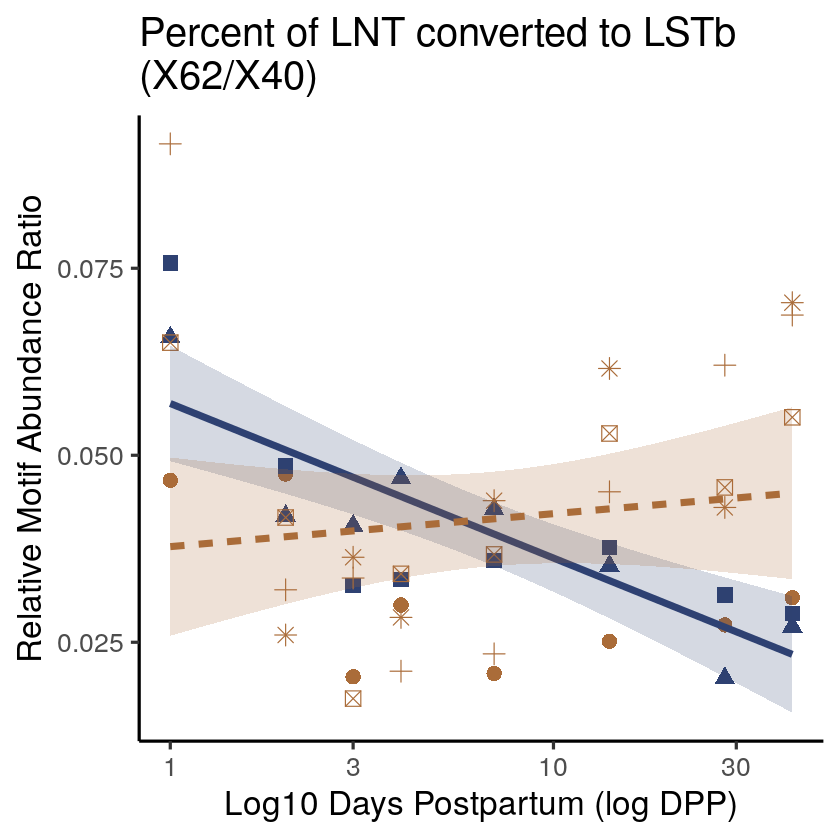

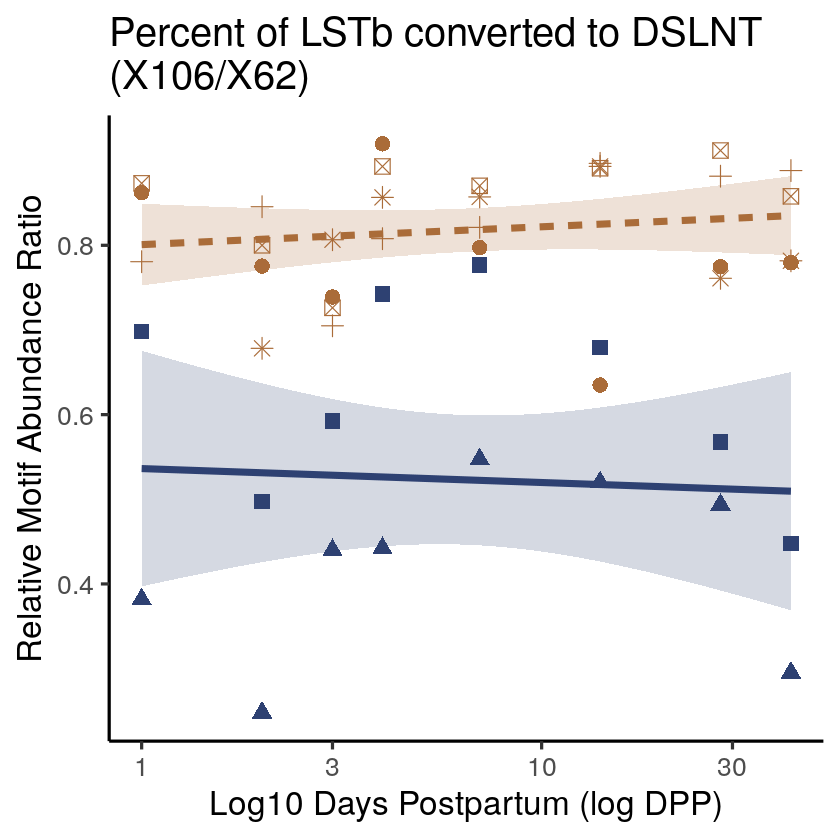

In [150]:

#g = grid.arrange(grobs=list(
    ggplot(data[[1]],aes(x=DPP,y=X62/X40,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='glm',size=2,se=TRUE,aes(fill=Secretor),alpha=.2,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LNT converted to LSTb\n(X62/X40)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+scale_fill_manual(values=c("#2E4172", "#AA6C39")) #,
    ggplot(data[[1]],aes(x=DPP,y=X106/X62,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(Secretor)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='glm',size=2,se=TRUE,aes(fill=Secretor),alpha=.2,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Relative Motif Abundance Ratio')+
        ggtitle("Percent of LSTb converted to DSLNT\n(X106/X62)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+scale_fill_manual(values=c("#2E4172", "#AA6C39"))
#),nrow=2)
#ggsave(g,filename='~/Desktop/fig5.pdf',width=7,height=10)

# Power Analysis

In [3]:
data2 = cbind(data$smallest_motif_abundance_dropped_more,data$glycan_percent[,colnames(data$glycan_percent)%in%vars])
data2$Secretor = as.numeric(data2$Secretor)


In [58]:
model_list1 <- lapply( colnames(data2)[colnames(data2)%in%vars] , function(v){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale((',v,'+1e-6)^(1/2))~ Secretor*log(DPP)')),
                        id=PateintID,data=data2,corstr='exchangeable'))
        return(mod)
    })
names(model_list1)=colnames(data2)[colnames(data2)%in%vars]

model_list2 <- lapply( colnames(data2)[colnames(data2)%in%vars] , function(v){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale((',v,'+1e-6)^(1/2))~ Secretor+log(DPP)')),
                        id=PateintID,data=data2,corstr='exchangeable'))
        return(mod)
    })
names(model_list2)=colnames(data2)[colnames(data2)%in%vars]

model_list3 <- lapply( colnames(data2)[colnames(data2)%in%vars] , function(v){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale((',v,'+1e-6)^(1/2))~ Secretor')),
                        id=PateintID,data=data2,corstr='exchangeable'))
        return(mod)
    })
names(model_list3)=colnames(data2)[colnames(data2)%in%vars]

model_list4 <- lapply( colnames(data2)[colnames(data2)%in%vars] , function(v){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale((',v,'+1e-6)^(1/2))~ log(DPP)')),
                        id=PateintID,data=data2,corstr='exchangeable'))
        return(mod)
    })
names(model_list4)=colnames(data2)[colnames(data2)%in%vars]

model_list = list(model_list1,model_list2,model_list3,model_list4)

## parse to matrix

df<-do.call(rbind,lapply(model_list,function(mli){
    
    do.call(rbind,lapply(names(mli),function(xn){
    x = mli[[xn]]
    df_i=coef(summary(x))
    df_i$sugar_measure = xn
    df_i$measure_type = ifelse(grepl('^X',xn),'motif','glycan')
    df_i$observed = gsub('\\(|\\)','',rownames(df_i))
    # get stats
    df_i = cbind(df_i,t(parseSummary.GEEpack(x,logit=FALSE)[[2]]))
    #df$cohenD = c(NA,chnD(x,xn)) #[1:3]
    # clean colnames
    colnames(df_i) = make.names(gsub('\\(|\\)|\\||\\>','',colnames(df_i)))    
    df_i
    }))

    
}))
head(df)

,Estimate,Std.err,Wald,Pr.W,sugar_measure,measure_type,observed,Number.of.observations,Number.of.Clusters,Marginal.R.2,Marginal.Entropy,Degrees.of.Freedom,Shapiro.Wilks.P
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.23696727,0.21315551,33.6762149,6.509173e-09,X1,motif,Intercept,47,6,0.445,NA,43,2.210609e-04
Secretor,-0.33243619,0.47059843,0.4990174,4.799322e-01,X1,motif,Secretor,47,6,0.445,NA,43,2.210609e-04
log(DPP),-0.59419919,0.10645112,31.1575742,2.379093e-08,X1,motif,logDPP,47,6,0.445,NA,43,2.210609e-04
Secretor:log(DPP),0.08408052,0.17159455,0.2400954,6.241373e-01,X1,motif,Secretor:logDPP,47,6,0.445,NA,43,2.210609e-04
(Intercept)1,-1.18733039,0.05528734,461.2026178,0.000000e+00,X4,motif,Intercept,47,6,0.762,NA,43,5.548047e-05
Secretor1,1.69449974,0.23615000,51.4881305,7.203127e-13,X4,motif,Secretor,47,6,0.762,NA,43,5.548047e-05


 [1] "X1"      "X4"      "X8"      "X13"     "X15"     "X18"     "X32"    
 [8] "X34"     "X35"     "X37"     "X40"     "X61"     "X62"     "X63"    
[15] "X64"     "X65"     "X66"     "X94"     "X106"    "X113"    "X120"   
[22] "X127"    "X141"    "X142"    "X143"    "X2FL"    "X3FL"    "LNnT"   
[29] "X3SL"    "LNT"     "LNFPI"   "LNFPII"  "LNFPIII" "LSTb"    "LSTc"   
[36] "DFLNT"   "DSLNT"   "FLNH"    "DFLNH"   "FDSLNH"  "DSLNH"  


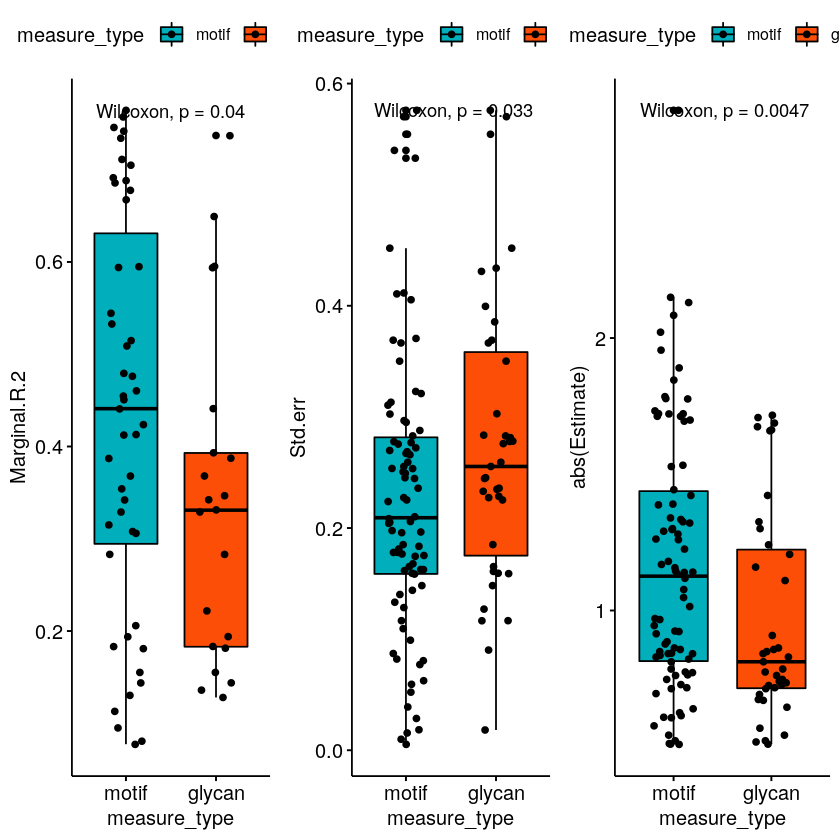

In [61]:
keep = df$Shapiro.Wilks.P>.001 & abs(df$Estimate)>.5 # & (df$observed=='Secretor' | df$observed=='logDPP')

keep_cols = c('measure_type','Marginal.R.2','Estimate','Std.err','cohenD')

g1=ggboxplot(unique(df[keep,keep_cols[c(1,2)]]), x = "measure_type", y = "Marginal.R.2",
                fill = "measure_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

g2=ggboxplot(unique(df[keep,keep_cols[c(1,3)]]), x = "measure_type", y = "abs(Estimate)",
                fill = "measure_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

g3=ggboxplot(unique(df[keep,keep_cols[c(1,4)]]), x = "measure_type", y = "Std.err",
                fill = "measure_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "greater"))

#  g4=ggboxplot(unique(df[keep,keep_cols[c(1,5)]]), x = "measure_type", y = "abs(cohenD)",
#                  fill = "measure_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                  add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

# g1=ggplot(df[keep,], aes(y = Marginal.R.2, x = abs(Estimate), ,col=measure_type)) +
#     stat_smooth(method='lm')+geom_point()+theme_classic()+guides(col = "none")
# g2=ggplot(df[keep,], aes(y = Marginal.R.2, x = Std.err, ,col=measure_type)) +
#     stat_smooth(method='lm')+geom_point()+theme_classic()+guides(col = "none")
# g3=ggplot(df[keep,], aes(y = Marginal.R.2, x = log(abs(Wald)), ,col=measure_type)) +
#     stat_smooth(method='lm')+geom_point()+theme_classic()+guides(col = "none")
# g4=ggplot(df[keep,], aes(y = Marginal.R.2, x = -log(Shapiro.Wilks.P,10), ,col=measure_type)) +
#     stat_smooth(method='lm')+geom_point()+theme_classic()+guides(col = "none")

#summary(glm(Marginal.R.2 ~ abs(Estimate)*measure_type, data=df[keep,]))
g<-grid.arrange(grobs=list(g1,g3,g2),nrow=1)

print(unique(df$sugar_measure))

ggsave(g,filename = '~/Desktop/poweranyl.pdf',height=10,width=10)

### rate of increase in power (by sample size)

In [128]:

# examine distributions of marginal r^2

mr2.g<-df$Marginal.R.2[ keep & df$measure_type=='glycan']
mr2.m<-df$Marginal.R.2[ keep & df$measure_type=='motif']

# library(diptest)
# dip.test(mr2.m)
# dip.test(mr2.g)

# library(mixtools)
# (gmm.m<-normalmixEM(mr2.m ,maxit = 10000,maxrestarts = 100 ))[c('mu','sigma','loglik')]
# (gmm.g<-normalmixEM(mr2.g ,maxit = 10000,maxrestarts = 100 ))[c('mu','sigma','loglik')]
# par(mfrow = c(2,2)); plot(gmm.m,density=TRUE); plot(gmm.g,density=TRUE)

q=data.frame(motifs=quantile(mr2.m),glycans=quantile(mr2.g))
(q)

,motifs,glycans
,<dbl>,<dbl>
0%,0.0774,0.128
25%,0.3065,0.181
50%,0.4530,0.331
75%,0.6840,0.441
100%,0.7640,0.737


n,power,quantile,quant_perc,type
<dbl>,<dbl>,<dbl>,<fct>,<fct>
5,0.05476288,0.0774,0%,motif
6,0.05260176,0.0774,0%,motif
7,0.05243749,0.0774,0%,motif
8,0.05284712,0.0774,0%,motif
9,0.05346176,0.0774,0%,motif
10,0.05415825,0.0774,0%,motif


,motifs,glycans,factor
,<dbl>,<dbl>,<dbl>
0.8,36,69,0.5217391
0.9,47,91,0.5164835
0.95,57,112,0.5089286
0.99,80,158,0.5063291


Warning message:
“Ignoring unknown parameters: aes”

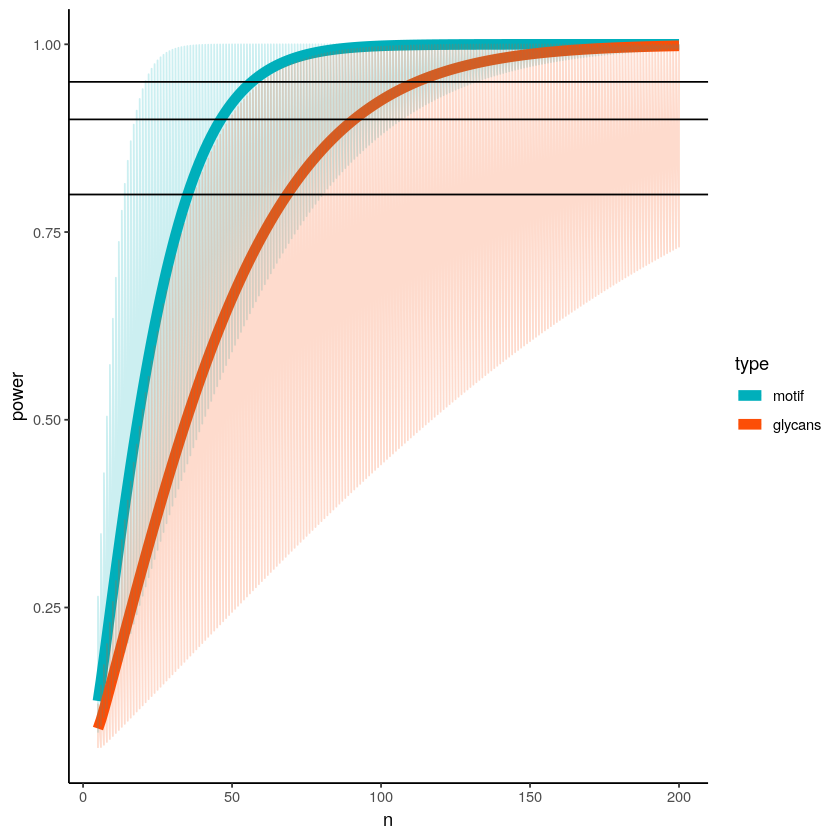

In [145]:
library('pwr')

df2 = rbind( 
    do.call(rbind,lapply(rownames(q),function(qn){
        qi = q$motifs[rownames(q)==qn]
        data.frame(pwr.r.test(n = seq(5,200,1), r =qi ,sig.level =0.05 )[c('n','power')],quantile=qi,quant_perc=qn,type='motif')
        })),
    do.call(rbind,lapply(rownames(q),function(qn){
        qi = q$glycans[rownames(q)==qn]
        data.frame(pwr.r.test(n = seq(5,200,1), r =qi ,sig.level =0.05 )[c('n','power')],quantile=qi,quant_perc=qn,type='glycans')
        })))
head(df2)

thresh = data.frame(motifs=c(min(df2$n[ df2$type=='motif' & df2$quant_perc=='50%' & df2$power>=.8]),
                             min(df2$n[ df2$type=='motif' & df2$quant_perc=='50%' & df2$power>=.9]),
                             min(df2$n[ df2$type=='motif' & df2$quant_perc=='50%' & df2$power>=.95]),
                             min(df2$n[ df2$type=='motif' & df2$quant_perc=='50%' & df2$power>=.99])),
                    glycans=c(min(df2$n[ df2$type=='glycans' & df2$quant_perc=='50%' & df2$power>=.8]),
                             min(df2$n[ df2$type=='glycans' & df2$quant_perc=='50%' & df2$power>=.9]),
                             min(df2$n[ df2$type=='glycans' & df2$quant_perc=='50%' & df2$power>=.95]),
                             min(df2$n[ df2$type=='glycans' & df2$quant_perc=='50%' & df2$power>=.99])),
                   row.names=c(.8,.9,.95,.99))
thresh$factor = thresh$motifs / thresh$glycans
thresh
gg<-ggplot(df2[df2$quant_perc %in% '50%',],aes(x=n,y=power,color=type))+
            geom_line(size=3)+scale_color_manual(values=c("#00AFBB",'#FC4E07'))+
            geom_line(data=df2[df2$quant_perc %in% c('25%','75%'),],aes=aes(x=n,y=power,color=type),linetype=1,alpha=.2)+
            theme_classic()+
            geom_hline(yintercept = .8)+geom_hline(yintercept = .9)+geom_hline(yintercept = .95)
gg
ggsave(gg,filename = '~/Desktop/poweranyl2.pdf',height=10,width=10)

### paired wilcoxon test & bootsrapping

In [857]:
# ########################
# # paired wilcoxon


# paired_wilcox <- function(var,alt,f){
#     print(var)
#     matcher=do.call(rbind,
#             list(c('X37','LNnT'),c('X40','LNT'),c('X61','LSTc'),c('X62','LSTb'),
#                  c('X63','LNFPIII'),c('X64','LNFPII'),c('X65','LNFPI'),c('X94','LNH'),c('X106','DSLNT'),
#                  c('X113','DFLNT'),c('X120','FLNH'),c('X141','DSLNH'),c('X142','DFLNH'),c('X143','FDSLNH')))
#     colnames(matcher)=c('motif','glycan')


#     tmp = unique(df[keep,c('measure_type',var,'sugar_measure')])

#     dat_tmp = na.omit(do.call(rbind,apply(matcher,1,function(x){
#         g = x[1]; m = x[2]
#     #    print(x[x%in%tmp$sugar_measure])
#         if(!all(x%in%tmp$sugar_measure)){return(NA)}
#         data.frame(
#             m=tmp[[var]][tmp$sugar_measure==m],
#             g=tmp[[var]][tmp$sugar_measure==g],
#             motif=m,glycan=g
#         )
#     })))
#     dat_tmp$g = f(dat_tmp$g)
#     dat_tmp$m = f(dat_tmp$m)

#     list(mnsd=t(do.call(cbind,list(mean=signif(apply(dat_tmp[,c('m','g')],2,mean),4),
#                         sd=signif(apply(dat_tmp[,c('m','g')],2,sd),4)))),
#         wilcox.p = wilcox.test(dat_tmp$g,dat_tmp$m,paired = TRUE,alternative=alt,var.equal = TRUE,exact = TRUE)$p.value)
# }

# wcx.p=list(paired_wilcox('Marginal.R.2','greater',I),
# paired_wilcox('cohenD','greater',abs),
# paired_wilcox('Estimate','greater',abs),
# paired_wilcox('Std.err','less',I))

# lapply(wcx.p,function(x) x[[2]])

# ###################
# # bootrap t-test
# library(nonpar)


# var = 'Marginal.R.2'; alt = 'greater'; f = I
# #var = 'cohenD'; alt = 'greater'; f = abs
# #var = 'Estimate'; alt = 'greater'; f = abs
# #var = 'Std.err'; alt = 'less'; f = I

#     tmp = na.omit(unique(df[keep,c('measure_type',var,'sugar_measure')]))

# boot.t.test(f(tmp[[var]][tmp$measure_type=='motif']), f(tmp[[var]][tmp$measure_type=='glycan']),
#             reps = 10000, mu = 0, alternative = alt)

## Using the likelihood ratio test to determine if more complex substructures are significantly more predictive of secretor status 

In [63]:
#### load heirachy
r = read.csv('motifAnyl/motif_heir.12.7.18.Bokan/edges.txt',header=F)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data[[1]]

comp=list()
comp_clean=list()
for( e in E(heir)){
    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));
        next
    }
    # run models
    f1 = as.formula(paste('Secretor ~',paste0('X',en[1])))
    f2 = as.formula(paste('Secretor ~',paste(paste0('X',en),collapse='+')  ))
    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    aov = anova(m1,m2,test='LRT')
    out = data.frame( rbind(coef(summary(m1)) , coef(summary(m2))) )
    out$model = c(rep('m1',2),rep('m2',3))
    out$iter = paste(en,collapse='_')
    eni = c('Intercept',en)
    out$vars = c(eni[1:2],eni[1:3])
    out$LRT = aov[[3]]
    if(any(abs(out$Estimate)>15)){next}
    comp[[paste(en,collapse='_')]] = list(m1,m2,aov)
    comp_clean[[paste(en,collapse='_')]] = out
}
head(do.call(rbind,comp_clean))



     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "43"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "51"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "53"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "26" "43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "79"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
     [,1] [,2]
[1,] "51" "74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
     [,1] [,2]
[1,] "51" "81"
     [,1] [,2]
[1,] "51" "85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
     [,1] [,2] 
[1,] "62" "113"
     [,1] [,2] 
[1,] "63" "113"
     [,1] [,2] 
[1,] "63" "116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
     [,1] [,2] 
[1,] "73" "116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
     [,1] [,2]
[1,] "75" "98"
     [,1] [,2]
[1,] "75" "99"
     [,1] [,2] 
[1,] "75" "102"
     [,1] [,2] 
[1,] "75" "104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_100"
     [,1] [,2] 
[1,] "76" "101"
[1] "skip 76_101"
     [,1] [,2] 
[1,] "76" "102"
[1] "skip 76_102"
     [,1] [,2] 
[1,] "79" "103"
[1] "skip 79_103"
     [,1] [,2] 
[1,] "79" "108"
     [,1] [,2] 
[1,] "80" 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
     [,1] [,2] 
[1,] "85" "109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
     [,1] [,2] 
[1,] "86" "112"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
     [,1] [,2] 
[1,] "97" "130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
     [,1] [,2] 
[1,] "98" "135"
     [,1] [,2] 
[1,] "98" "136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
     [,1] [,2] 
[1,] "99" "131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_122"
     [,1]  [,2] 
[1,] "100" "123"
[1] "skip 100_123"
     [,1]  [,2] 
[1,] "101" "122"
[1] "skip 101_122"
     [,1]  [,2] 
[1,] "101" "124"
[1] "skip 101_124"
     [,1]  [,2] 
[1,] "102" "123"
[1] "skip 102_123"
     [,1]  [,2] 
[1,] "102" "124"
[1] "skip 102_124"
     [,1]  [,2] 
[1,] "103" "126"
     [,1]  [,2] 
[1,] "104" "128"
[1] "skip 104_128"
     [,1]  [,2] 
[1,] "108" "126"
[1] "skip 108_126"
     [,1]  [,2] 
[1,] "108" "127"
[1] "skip 108_127"
     [,1]  [,2] 
[1,] "109" "126"
[1] "skip 109_126"
     [,1]  [

,Estimate,Std.err,Wald,Pr...W..,model,iter,vars,LRT
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
26_43.(Intercept),0.69494924,0.86693136,0.6425941,0.4227730,m1,26_43,Intercept,0.1158514
26_43.X26,-0.01889897,0.02903672,0.4236243,0.5151341,m1,26_43,26,0.1158514
26_43.(Intercept)1,0.69710437,0.86682828,0.6467396,0.4212808,m2,26_43,Intercept,0.1158514
26_43.X261,0.09174131,0.06288704,2.1281759,0.1446128,m2,26_43,26,0.1158514
26_43.X43,-0.16576369,0.10543322,2.4718600,0.1159007,m2,26_43,43,0.1158514
53_81.(Intercept),0.68414491,0.86525408,0.6251855,0.4291268,m1,53_81,Intercept,0.9929525


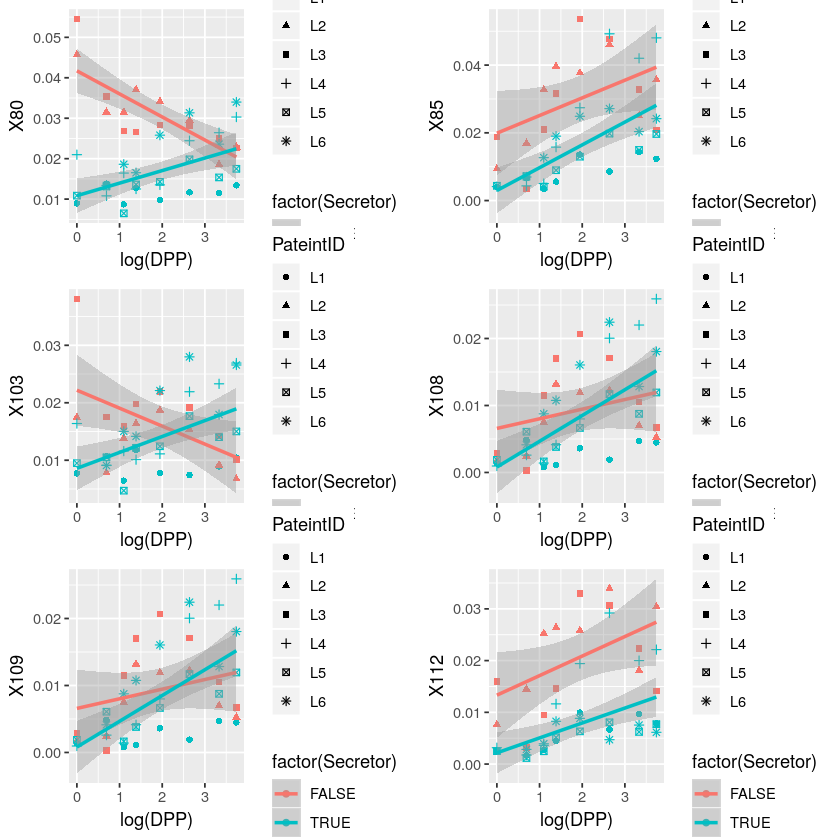

In [61]:
g=grid.arrange(grobs=list(
	ggplot(data[[1]],aes(x=log(DPP),y=X80,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X85,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X103,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X108,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X109,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X112,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm')
	))

In [73]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] geepack_1.2-1       gee_4.13-19         heatmap.plus_1.3   
 [4] lme4_1.1-21         openxlsx_4.1.0.1    reshape2_1.4.3     
 [7] metap_1.1           GGally_1.4.0        ggrepel_0.8.1      
[10] colorRamps_2.3      stringr_1.4.0       MASS_7.3-51.4 

# Trash

In [870]:
library(gee)


i=0
out_i=lapply( data, function(x){
    i=i+1
    all_models=list()
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    all_models = c(all_models,mods_i)
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
        try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ Secretor')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    all_models = c(all_models,mods_i)
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods2=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
#     mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
#         mod=NA
#         #try(mod<-gee(as.formula(paste(motif,'~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family=Gamma()))
#         try(mod<-gee(as.formula(paste('scale(log(',motif,'+.001))~ PateintID')),id=Secretor,data=droplevels(x),corstr='exchangeable'))
#         #try(mod<-gee(as.formula(paste('Secretor~scale(',motif,')+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable',family='binomial'))
#         if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
#     })
#     names(mods_i) = colnames(x)[colnames(x)%in%vars]
#     all_models = c(all_models,mods_i)
#     mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
#     mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
#     colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
#     mods$type = 'additive'
#     mods$robustPr = 2*pnorm(-abs(mods$robustZ))
#     mods3=mods[mods$response%in%vars & mods$vars!='Intercept',]
    
    rbind(mods1,mods2) #,mods3)#,all_models)
})
#out_clean = lapply(out_i,function(x) x[[1]])
#out_models = lapply(out_i,function(x) x[[2]])
#names(out_mods)=names(data)
   
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))
                         
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))



Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      1.043      -0.551 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0810      0.0428 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.1568     -0.0828 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1311      0.0692 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.640      -0.338 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.262       0.138 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1322      0.0698 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.663      -0.350 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0681      0.0360 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.528      -0.279 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.375       0.198 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.965      -0.510 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1681      0.0887 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
   -0.01675     0.00884 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.201       0.106 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.133       0.070 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.620       0.328 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.925       0.489 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.231       0.122 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.343       0.181 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.750       0.396 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.270       0.143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.919       0.485 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.506       0.267 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.304      -0.160 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.166      -0.251 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.19        1.81 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.854      -1.295 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.35        2.05 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.156       0.236 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.11       -1.68 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.458       0.695 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.213       0.323 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.36        2.06 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.726      -1.101 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.07       -1.62 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.356      -0.540 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.913      -1.384 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.802      -1.216 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.08       -1.64 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.19        1.80 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.813      -1.233 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.602      -0.913 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.263      -0.399 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.492       0.746 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.832      -1.261 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       0.84       -1.27 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.158      -0.239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.892      -1.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.475      -0.719 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0681      0.0360 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.337      -0.178 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0686     -0.0363 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.663      -0.350 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.547       0.289 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.0353      0.0187 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
    -0.1007      0.0532 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.515      -0.272 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     0.0252     -0.0133 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.962      -0.508 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.343       0.181 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.897      -0.474 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.750       0.396 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.506       0.267 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
      0.304      -0.160 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    log(DPP) 
     -0.919       0.485 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.36        2.06 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.623      -0.945 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.484      -0.734 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.213       0.323 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.976      -1.480 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      -1.28        1.94 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.20       -1.83 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.305       0.463 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
       1.22       -1.84 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.263      -0.398 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
     -0.492       0.746 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
    -0.0672      0.1019 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.832      -1.261 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.892      -1.353 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.475      -0.719 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor 
      0.158      -0.239 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”

In [871]:
library(geepack) 
              
# get whole models
out_models=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    mods_1 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ Secretor')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_1) = paste(colnames(x)[colnames(x)%in%vars],'secretor',sep='_')
    
    mods_2 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NA)}else{mod}
    })
    names(mods_2) = paste(colnames(x)[colnames(x)%in%vars],'dpp',sep='_')
    
#     mods_3 = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
#         mod=NA
#         try(mod<-geeglm(as.formula(paste('scale(log(',motif,'+.0001))~ PateintID')),id=Secretor,data=droplevels(x),corstr='exchangeable'))
#         if(is.na(mod)){return(NA)}else{mod}
#     })
#     names(mods_3) = paste(colnames(x)[colnames(x)%in%vars],'subject',sep='_')
    
    
    c(mods_1,mods_2) #,mods_3)
})

Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Warning message in if (is.na

In [872]:


### check normality
x=data$glycan_percent
p1=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))
x=data$smallest_motif_abundance_dropped_more
p2=unlist(apply( x[colnames(x)[colnames(x)%in%vars]],2,function(y){
    out=NULL;
    try(out<-shapiro.test(scale(log(y+.001)))$p.value);
    out} ))

thresh=.1
pn = c(names(p1)[p.adjust(p1,'fdr')>thresh],names(p2)[p.adjust(p2,'fdr')>thresh])
print(pn)

x1=data$smallest_motif_abundance_dropped_more
x2=data$glycan_percent
vars1 = colnames(x1)[colnames(x1)%in%pn]
vars2 = colnames(x2)[colnames(x2)%in%pn]


#par(mfrow = c(1,3))

##### marginal r^2
keep1=grepl(paste(vars1,collapse='|'),names(out_models$smallest_motif_abundance_dropped_more))
keep2=grepl(paste(vars2,collapse='|'),names(out_models$glycan_percent))
mr2<-list(motifs=sapply(out_models$smallest_motif_abundance_dropped_more[keep1],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }),
    glycans=sapply(out_models$glycan_percent[keep2],function(mod){
        y = mod$y; y_bar=mean(y); y_hat=mod$fitted.values
        mr2=1-sum((y-y_hat)^2)/sum((y-y_bar)^2)
        mr2
    }))

### cohen's d

chnD<-list(
    motifs=unlist(lapply(vars1[vars1%in%pn],function(yn){
    y=x1[,yn]
    c(cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
        hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate,
      cohen.d(y,cut(log(x$DPP),2), pooled=TRUE, paired=FALSE, na.rm=T, 
        hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate)
    })),
    glycans=unlist(lapply(vars2[vars2%in%pn],function(yn){
        y=x2[,yn]
        c(cohen.d(y,factor(x$Secretor), pooled=TRUE, paired=FALSE, na.rm=T, 
            hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate,
          cohen.d(y,cut(log(x$DPP),2), pooled=TRUE, paired=FALSE, na.rm=T, 
            hedges.correction = FALSE, conf.level = 0.95, noncentral = FALSE)$estimate)
})))



###### coeffiecients and noise

keep = out$type=='additive' & out$data%in%keep_data & 
    out$response%in%pn & #!grepl('DPP',rownames(out)) &
    out$robustPr<0.01


 [1] "X3FL"    "LNnT"    "LNFPIII" "LSTc"    "DSLNT"   "FLNH"    "DFLNH"  
 [8] "FDSLNH"  "DSLNH"   "X1"      "X8"      "X32"     "X62"     "X64"    
[15] "X66"     "X106"    "X120"    "X127"    "X141"    "X142"    "X143"   


In [59]:
# tmp=melt(chnD)
# colnames(tmp)=c('CohenD','abundance_type')
# p1=ggboxplot(tmp, x = "abundance_type", y = "abs(CohenD)",
#                 fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

# tmp=melt(mr2)
# colnames(tmp)=c('marginal_R2','abundance_type')
# p2=ggboxplot(tmp, x = "abundance_type", y = "marginal_R2",
#                 fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

# p3=ggboxplot(droplevels(out[keep,]),x='data',y='abs(Coef)',
#                 fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

# p6=ggboxplot(droplevels(out[keep,]),x='data',y='-log(robustPr,10)',
#                 fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

# p4=ggboxplot(droplevels(out[keep,]),x='data',y='log(robustSE)',
#                 fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "greater"))

# p5=ggboxplot(droplevels(out[keep,]),x='data',y='abs(robustZ)',
#                 fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
#                 add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))


# #g1<-grid.arrange(grobs=list(p1,p2,p6),nrow=1)
# #g2<-grid.arrange(grobs=list(p3,p4,p5),nrow=1)
# #g = grid.arrange(grobs=list(p1,p2,p3,p4),nrow=1)
# g<-grid.arrange(grobs=list(p1,p2,p3,p4),nrow=2)
# ggsave(g,filename = '~/Desktop/poweranyl_old.pdf',height=10,width=10)

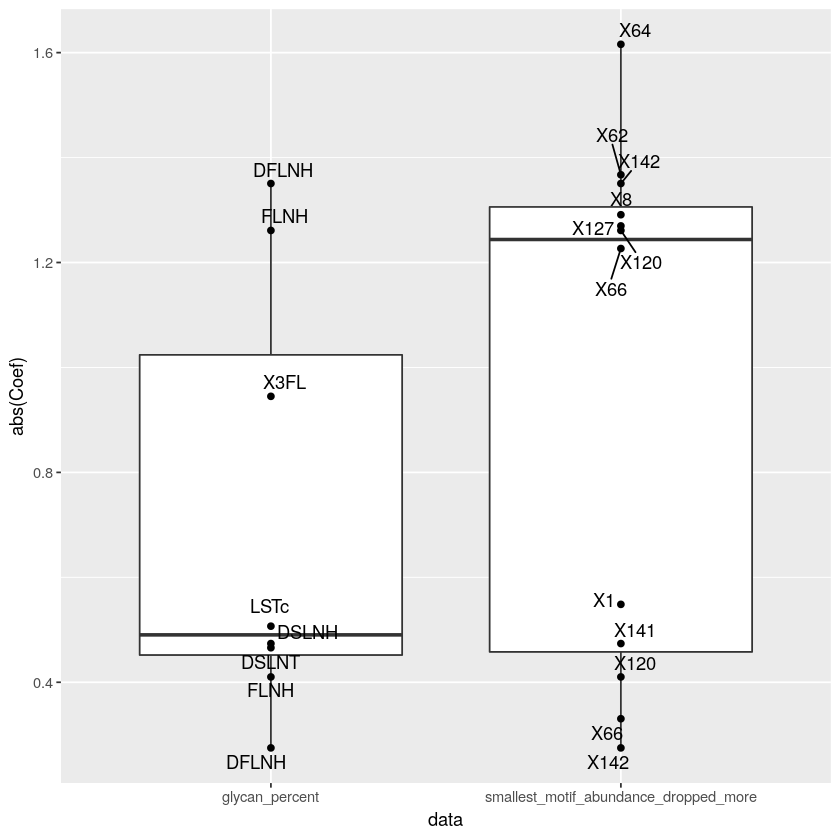

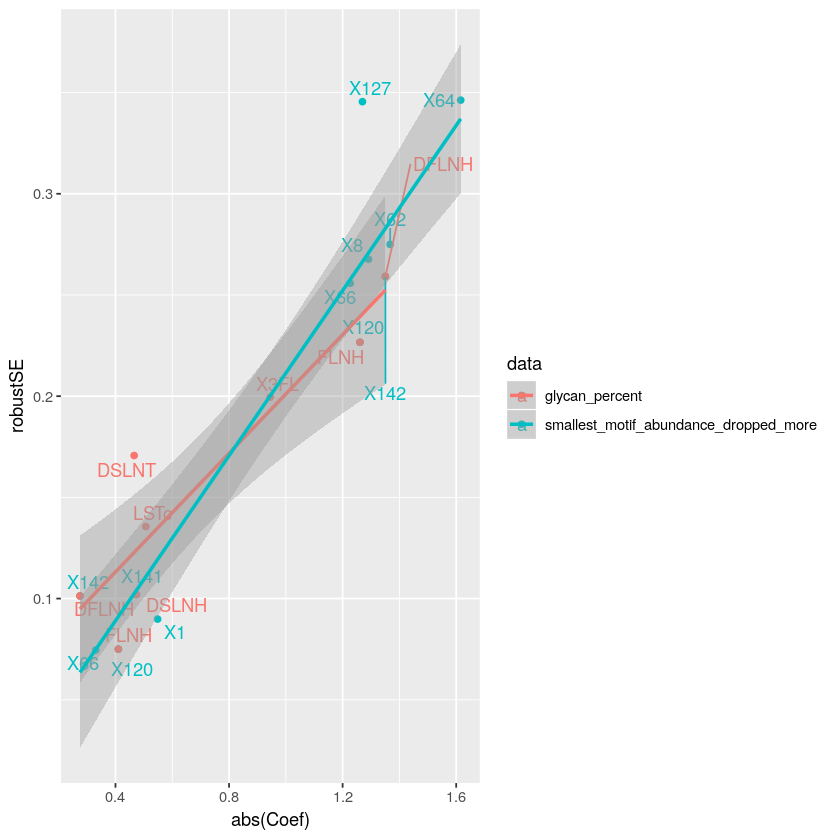

In [877]:
tmp=melt(chnD)
colnames(tmp)=c('CohenD','abundance_type')
p1=ggboxplot(tmp, x = "abundance_type", y = "abs(CohenD)",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

tmp=melt(mr2)
colnames(tmp)=c('marginal_R2','abundance_type')
p2=ggboxplot(tmp, x = "abundance_type", y = "marginal_R2",
                fill = "abundance_type", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

library(ggrepel)
ggplot(droplevels(out[keep,]),aes(x=data,y=abs(Coef),label=response))+
    geom_boxplot()+geom_point()+geom_text_repel()

ggplot(droplevels(out[keep,]),aes(color=data,x=abs(Coef),y=robustSE,label=response))+
    geom_point()+geom_text_repel()+stat_smooth(method='lm')

p6=ggboxplot(droplevels(out[keep,]),x='data',y='-log(robustPr,10)',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))

p4=ggboxplot(droplevels(out[keep,]),x='data',y='log(robustSE)',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "greater"))

p5=ggboxplot(droplevels(out[keep,]),x='data',y='abs(robustZ)',
                fill = "data", palette =c("#00AFBB",'#FC4E07'), #, "#E7B800"),
                add = "jitter")+stat_compare_means(method.args = list(alternative = "less"))


